# Finding differentially expressed genes (cluster biomarkers)

Seurat can help you find markers that define clusters via differential expression. By default, it identifes positive and negative markers of a single cluster (specified in ident.1), compared to all other cells. FindAllMarkers automates this process for all clusters, but you can also test groups of clusters vs. each other, or against all cells.

The __`min.pct`__ argument requires a gene to be detected at a minimum percentage in either of the two groups of cells, and the __`thresh.test`__ argument requires a gene to be differentially expressed (on average) by some amount between the two groups. 

You can set both of these to 0, but with a dramatic increase in time - since this will test a large number of genes that are unlikely to be highly discriminatory. As another option to speed up these computations, max.cells.per.ident can be set. 

This will downsample each identity class to have no more cells than whatever this is set to. While there is generally going to be a loss in power, the speed increases can be significiant and the most highly differentially expressed genes will likely still rise to the top.

## Find all markers of cluster 1

In [7]:
load(file="~/scrna_workshop/scrna_workshop_data/pbmc_from_sce.rds")
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(scater))
suppressPackageStartupMessages(library(monocle))
suppressPackageStartupMessages(library(dplyr))

In [8]:
cluster1.markers <- FindMarkers(object = pbmc, ident.1 = 1, min.pct = 0.25)
print(x = head(x = cluster1.markers, n = 5))

                p_val  avg_logFC pct.1 pct.2    p_val_adj
LDHB     6.731387e-93  0.7441801 0.940 0.602 1.119699e-88
CD3D     2.017834e-79  0.5814633 0.894 0.425 3.356465e-75
HLA-DRB1 2.743909e-70 -1.8775870 0.142 0.538 4.564218e-66
IL7R     5.572391e-69  0.9152596 0.705 0.325 9.269115e-65
HLA-DRA  5.400773e-64 -2.7664126 0.317 0.617 8.983646e-60


<div class="alert alert-block alert-warning">

__Notes__ : Find all markers distinguishing cluster 5 from clusters 0 and 3 <br><br>

```
    cluster5.markers <- FindMarkers(object = pbmc, ident.1 = 5, ident.2 = c(0, 3), min.pct = 0.25)
    print(x = head(x = cluster5.markers, n = 5))
```
</div>

 Find markers for every cluster compared to all remaining cells, report only the positive ones

In [28]:
pbmc.markers <- FindAllMarkers(object = pbmc, only.pos = TRUE, min.pct = 0.25, thresh.use = 0.25)
pbmc.markers %>% group_by(cluster) %>% top_n(2, avg_logFC)

p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
4.084393e-11,0.6407642,0.328,0.439,6.793979e-07,0,CAP1
9.041286e-06,0.5566313,0.200,0.276,1.503928e-01,0,NDUFA2
1.127300e-68,0.9037067,0.701,0.323,1.875150e-64,1,IL7R
8.821543e-46,0.7482095,0.359,0.115,1.467375e-41,1,AQP3
0.000000e+00,4.4740100,0.968,0.207,0.000000e+00,2,S100A9
0.000000e+00,4.1224400,0.932,0.115,0.000000e+00,2,S100A8
0.000000e+00,4.1238639,0.992,0.188,0.000000e+00,3,NKG7
1.251683e-142,4.0663459,0.591,0.111,2.082050e-138,3,GNLY
0.000000e+00,2.7777043,0.934,0.043,0.000000e+00,4,CD79A
1.689832e-184,2.3696654,1.000,0.818,2.810866e-180,4,CD74


<div class="alert alert-block alert-warning">

__NOTE__: __`Seurat`__ has several tests for differential expression which can be set with the test.use parameter (see the DE vignette for details). For example, the ROC test returns the ‘classification power’ for any individual marker (ranging from 0 - random, to 1 - perfect).
</div>

In [29]:
cluster1.markers <- FindMarkers(object = pbmc, ident.1 = 0, thresh.use = 0.25, test.use = "roc", only.pos = TRUE)

<div class="alert alert-block alert-warning">


__NOTE__: __`Seurat`__ includes several tools for visualizing marker expression

- ___VlnPlot___: shows expression probability distributions across clusters
- ___FeaturePlot___: visualizes gene expression on a tSNE or PCA plot) are our most commonly used visualizations.

The developers also suggest exploring RidgePlot, CellPlot, and DotPlot as additional methods to view your dataset.

</div>

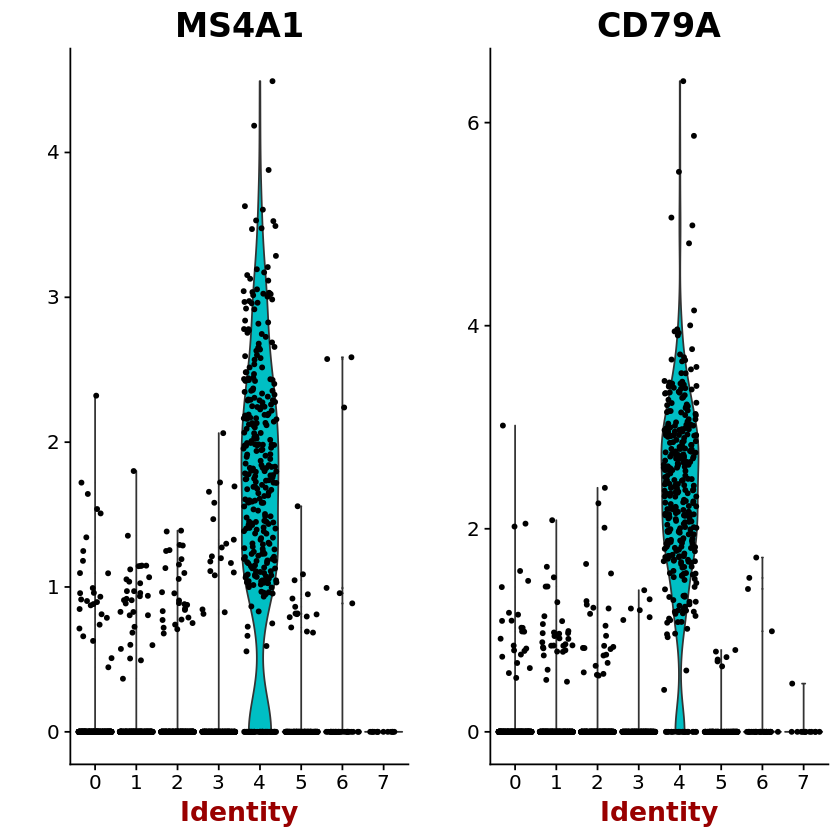

In [11]:
VlnPlot(object = pbmc, features.plot = c("MS4A1", "CD79A"))

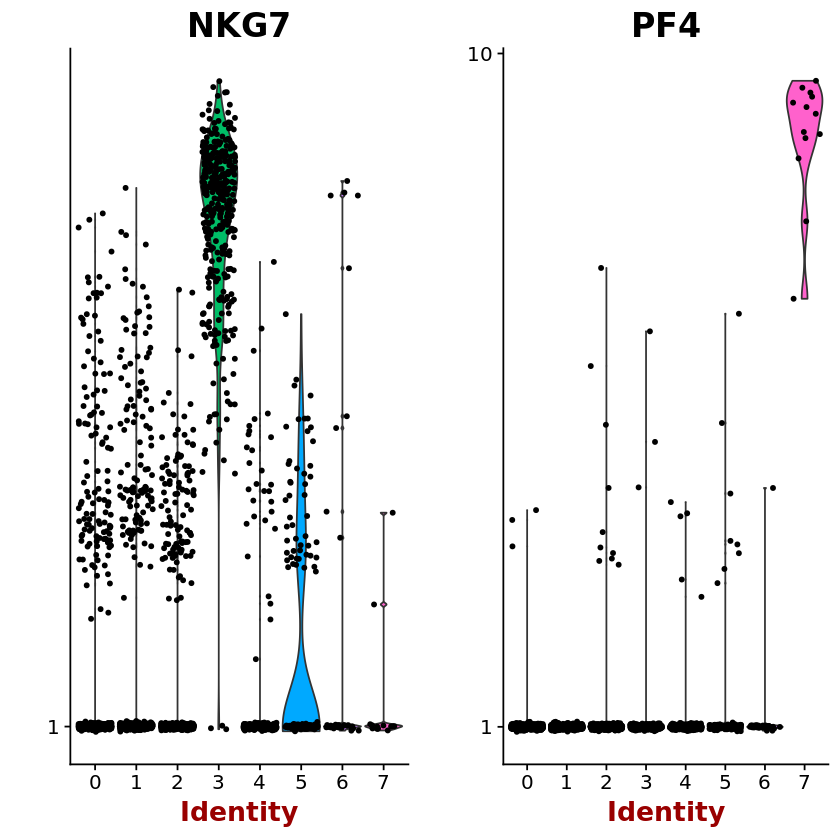

In [12]:
# you can plot raw UMI counts as well

VlnPlot(object = pbmc, features.plot = c("NKG7", "PF4"), use.raw = TRUE, y.log = TRUE)

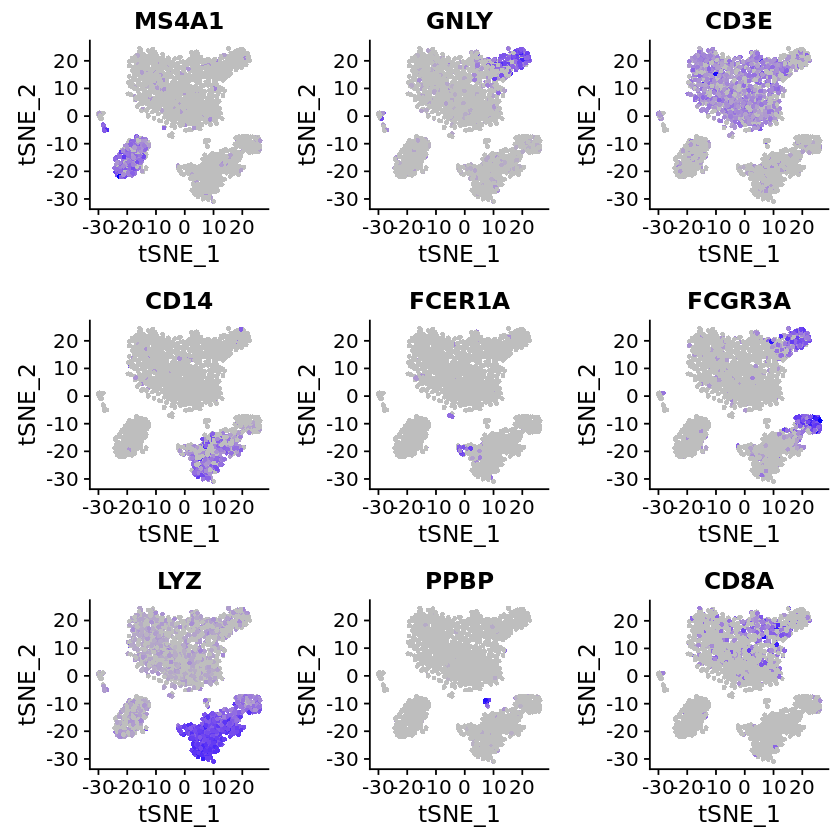

In [13]:
FeaturePlot(object = pbmc, features.plot = c("MS4A1", "GNLY", "CD3E", "CD14", 
    "FCER1A", "FCGR3A", "LYZ", "PPBP", "CD8A"), cols.use = c("grey", "blue"), 
    reduction.use = "tsne")

DoHeatmap generates an expression heatmap for given cells and genes. In this case, we are plotting the top 20 markers (or all markers if less than 20) for each cluster.

In [14]:
top10 <- pbmc.markers %>% group_by(cluster) %>% top_n(10, avg_logFC)


<div class="alert alert-block alert-warning"> 

__Note__: setting _`slim.col.label`_ to `TRUE` will print just the cluster IDS instead of every cell name 

</div>


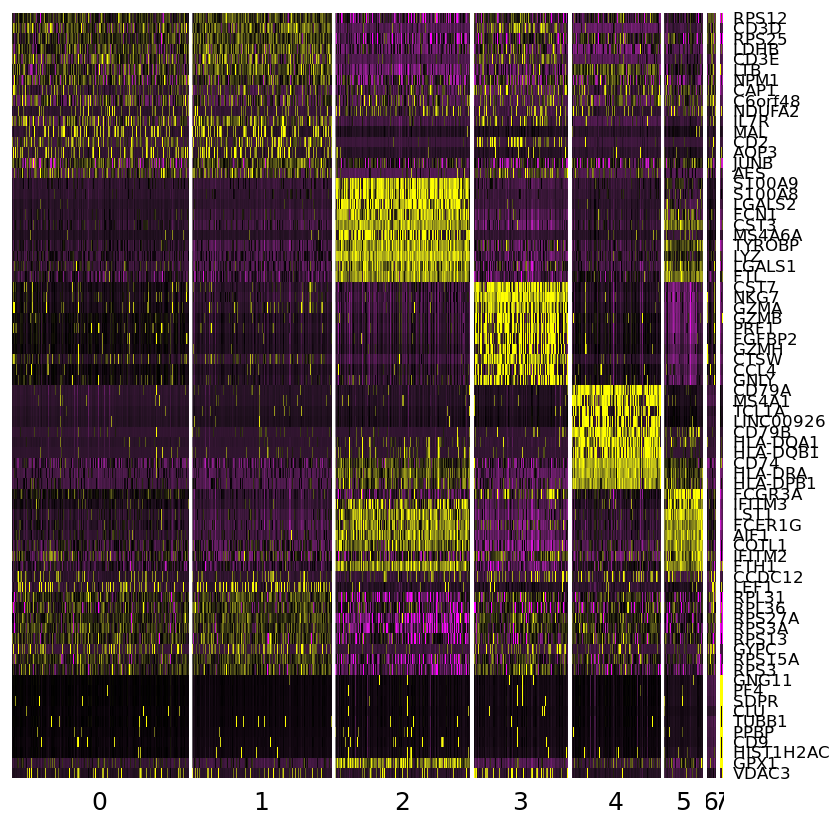

In [15]:
DoHeatmap(object = pbmc, genes.use = top10$gene, slim.col.label = TRUE, remove.key = TRUE)

# Assigning cell type identity to clusters



Fortunately in the case of this dataset, we can use canonical markers to easily match the unbiased clustering to known cell types:

    Cluster ID	Markers	Cell Type
    0	IL7R	CD4 T cells
    1	CD14, LYZ	CD14+ Monocytes
    2	MS4A1	B cells
    3	CD8A	CD8 T cells
    4	FCGR3A, MS4A7	FCGR3A+ Monocytes
    5	GNLY, NKG7	NK cells
    6	FCER1A, CST3	Dendritic Cells
    7	PPBP	Megakaryocytes


In [17]:
current.cluster.ids <- c(0, 1, 2, 3, 4, 5, 6, 7)

new.cluster.ids <- c("CD4 T cells", "CD14+ Monocytes",
                     "B cells", "CD8 T cells", "FCGR3A+ Monocytes",
                     "NK cells", "Dendritic cells", "Megakaryocytes")

# Further subdivisions within cell types



If we perturb some of our parameter choices above (for example, setting resolution=0.8 or changing the number of PCs), we might see the CD4 T cells subdivide into two groups. You can explore this subdivision to find markers separating the two T cell subsets. However, before reclustering (which will overwrite object@ident), we can stash our renamed identities to be easily recovered later.

## First lets stash our identities for later

In [20]:
pbmc <- StashIdent(object = pbmc, save.name = "ClusterNames_0.6")


<div class="alert alert-info" role="alert"> 

Note that if you set save.snn=T above, you don't need to recalculate the SNN, and can simply put:<br>

```pbmc <- FindClusters(pbmc,resolution = 0.8)```

</div>

In [21]:
pbmc <- FindClusters(object = pbmc, reduction.type = "pca", dims.use = 1:10, 
    resolution = 0.8, print.output = FALSE)

Warning message in BuildSNN(object = object, genes.use = genes.use, reduction.type = reduction.type, :
“Build parameters exactly match those of already computed and stored SNN. To force recalculation, set force.recalc to TRUE.”

## Demonstration of how to plot two tSNE plots side by side, and how to color points based on different criteria

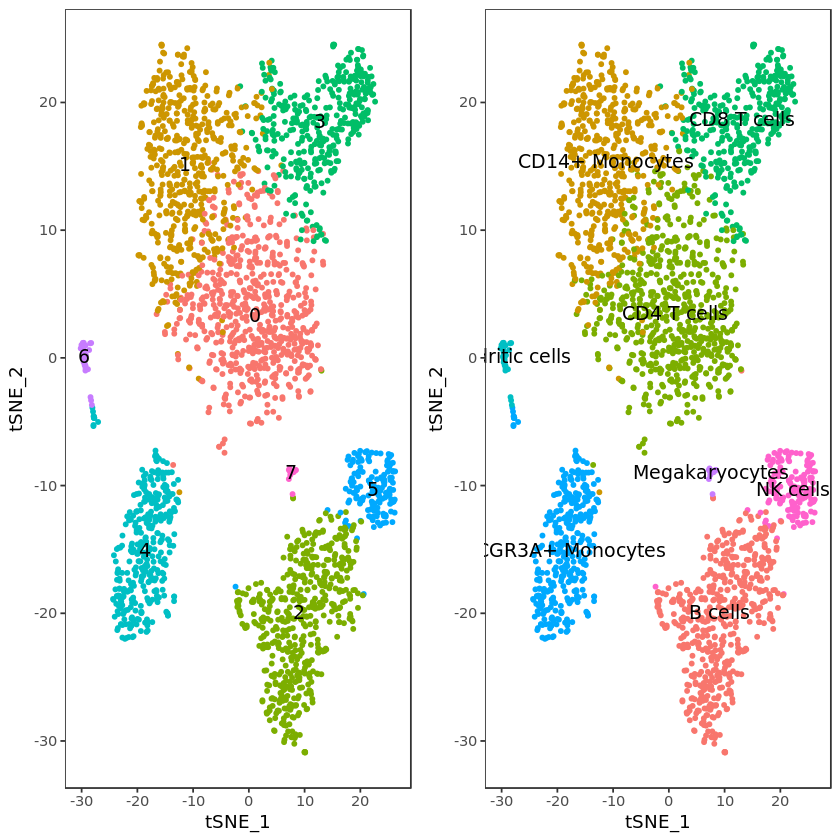

In [22]:
plot1 <- TSNEPlot(object = pbmc, do.return = TRUE, no.legend = TRUE, do.label = TRUE)
plot2 <- TSNEPlot(object = pbmc, do.return = TRUE, group.by = "ClusterNames_0.6", 
    no.legend = TRUE, do.label = TRUE)
plot_grid(plot1, plot2)

## Find discriminating markers

In [23]:
tcell.markers <- FindMarkers(object = pbmc, ident.1 = 0, ident.2 = 1)

Most of the markers tend to be expressed in C1 (i.e. S100A4). However, we can see that CCR7 is upregulated in C0, strongly indicating that we can differentiate memory from naive CD4 cells.  __`cols.use`__ demarcates the color palette from low to high expression

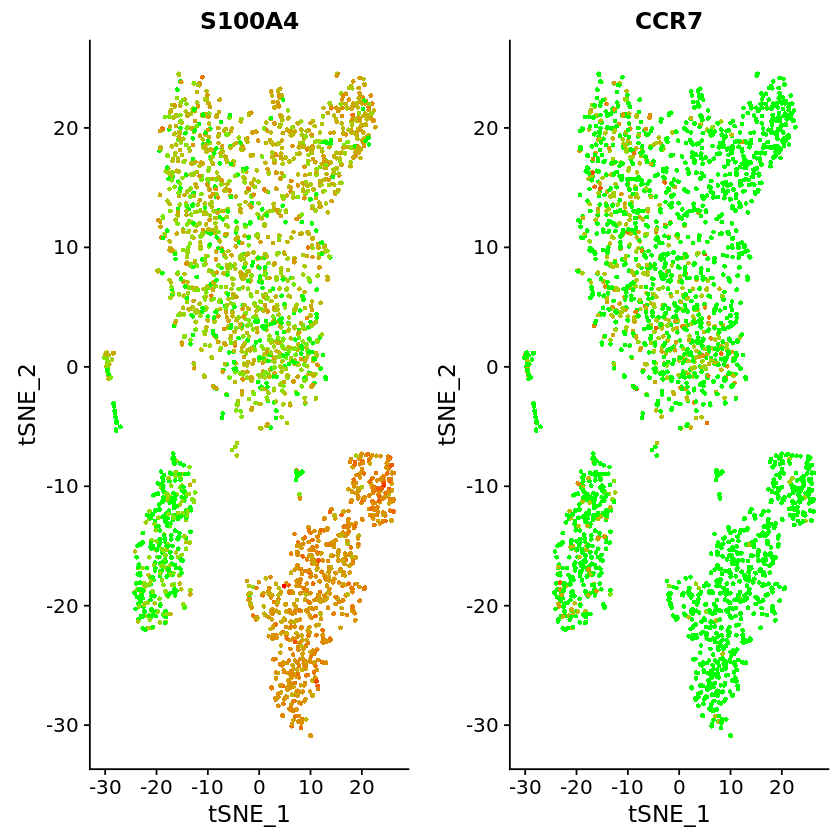

In [27]:
FeaturePlot(object = pbmc, features.plot = c("S100A4", "CCR7"), 
            cols.use = c("green", "red"))